# End to End Data Balance and Error Mitigation
This Notebook will demonstrate how to use both the Data Balance Analysis capabilities and error mitigation functions together using an example HR dataset which is a tabular dataset with a label column that indicates whether or not a person is promoted based on attributes such as education, gender, number of trainings, and other factors. 
The steps that we will take in this notebook are 
1. We will first conduct an analysis on how balanced the data is. 
2. We will train an example model to see how it performs on the data. 
3. We will try to balance the data to mitigate biases that may have resulted from unbalanced data
4. We will then compare model performance and data balance metrics before and after rebalancing the data

First we import all the dependencies needed in our analysis. This includes the classes to produce the data balance metrics, the sklearn functions to see the model performance and the error mitigation steps like DataRebalance and DataSplit that we apply to the dataset itself. 

In [6]:
!pip install -e ../../responsible-ai-mitigations

Obtaining file:///C:/Users/Akshara/Desktop/RAI/responsible-ai-mitigations
  Attempting uninstall: raimitigations
    Found existing installation: raimitigations 0.0.1
    Uninstalling raimitigations-0.0.1:
      Successfully uninstalled raimitigations-0.0.1
  Running setup.py develop for raimitigations


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE

from raimitigations.dataprocessing import Rebalance, Split

from raimitigations.databalanceanalysis import FeatureBalanceMeasure, AggregateBalanceMeasure, DistributionBalanceMeasure

from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder

### Train LightGBM Model
Now we import the tabular dataset that we will look at in the example, we load it into a pandas dataframe that we can then modify and use for all the other steps. For the data balance analysis portion we need our label columns and a list of sensitive columns that are interested in checking for balance. 

In [8]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd

outdirname = 'mitigations-datasets.2.22.2022'
zipfilename = outdirname + '.zip'
urlretrieve('https://publictestdatasets.blob.core.windows.net/data/' + zipfilename, zipfilename)
with zipfile.ZipFile(zipfilename, 'r') as unzip:
    unzip.extractall('.')
df = pd.read_csv('./' + outdirname + '/hr_promotion/train.csv')

We do some data transformation on the categorical columns in order to make the training data input in the format that the lightGBM model expects. Although lightGBM can internally deal with categorical columns that the user specifies, we need to encode those categories into integers before we are able to train the lightGBM model on it. 

In [9]:
cols_of_interest = ['education', 'recruitment_channel']
categorical_cols = ["department", "gender", "education", "region", "recruitment_channel" ]
label_col = 'is_promoted'
seed = 42
# handle duplicates
df = df.drop_duplicates().drop(["employee_id"], axis = 1)
df = df.dropna()
ord_enc = OrdinalEncoder(dtype = int)
df[categorical_cols] = ord_enc.fit_transform(df[categorical_cols])
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,7,31,2,0,2,1,35,5.0,8,1,0,49,0
1,4,14,0,1,0,1,30,5.0,4,0,0,60,0
2,7,10,0,1,2,1,34,3.0,7,0,0,50,0
3,7,15,0,1,0,2,39,1.0,10,0,0,50,0
4,8,18,0,1,0,1,45,3.0,2,0,0,73,0


Here we do a split on the data, train a LightGBM model, and see how this model does on some test data. After this processing, we train the model and we can see that the model does well on false values, getting 97.3% of them correct, but the model does a lot worse on the true values, only identifying approximately a third of the true positives correctly. 

In [10]:
## Train a model and get accuracy numbers

# data prep
def split_label(dataset):
    x = dataset.drop(['is_promoted'], axis=1)
    y = dataset['is_promoted']
    return x, y

dataset = df
target_index = dataset.columns.get_loc('is_promoted')
data_split =  Split(dataset,target_index , 0.9, 42, False, False, False, True)
train_data, test_data = data_split.split()
# splitting the training data
x_train, y_train = split_label(train_data)
# splitting the test data
x_test, y_test = split_label(test_data)

# LGBMClassifier Model
clf = LGBMClassifier(n_estimators=50, )
model = clf.fit(x_train, y_train, categorical_feature = categorical_cols)

pred = model.predict(x_test)

def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, normalize='true')
    return pd.DataFrame([[f'TP = {tp} ({tpr:1.2%})', f'FN = {fn} ({fnr:1.2%})'], 
                         [f'FP = {fp} ({fpr:1.2%})', f'TN = {tn} ({tnr:1.2%})']],
                        index=['True', 'False'], 
                        columns=['Pred 1', 'Pred 0'])

print("number of errors on test dataset: " + str(sum(pred != y_test)))

print(conf_matrix(y_test,pred))

print(classification_report(y_test, pred)) 


Using categorical_feature in Dataset.


number of errors on test dataset: 283
                  Pred 1              Pred 0
True   TP = 146 (34.52%)   FN = 277 (65.48%)
False     FP = 6 (0.14%)  TN = 4437 (99.86%)
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4443
           1       0.96      0.35      0.51       423

    accuracy                           0.94      4866
   macro avg       0.95      0.67      0.74      4866
weighted avg       0.94      0.94      0.93      4866



### Error Analysis on Baseline Model
Now that we have a baseline model to work with, we can see how this model is doing overall on the data and see if there are any cohorts within the data that it performs worse on. We use the [Error Analysis Dashboard](https://erroranalysis.ai/) to determine which cohorts of data this model performs worse on. Since the error analysis dashboard is interactive and too large to render on Github, we will include screenshots from our analysis. From these screenshots we can see that if we zoom in on certain cohorts that the model is getting more errors on, that region, department and education are all attributes that are involved in those cohorts. For the purpose of this example, we chose remove some of the other columns like KPIs_met from the error analysis since we want to focus on attributes that may lead to biases rather than more measurable attributes. We will focus on analyzing and mitigating errors within the department and education columns for the rest of the analysis. 

In [35]:
from raiwidgets import ErrorAnalysisDashboard
predictions = model.predict(x_test)
#ErrorAnalysisDashboard(dataset=x_test, true_y=y_test, features=x_test.columns, pred_y=predictions, categorical_features = categorical_cols)


![error_analysis1](images/error_analysis1.png)

### Data Balance Analysis
First we can take a look at the feature balance measures. These measures indicate the difference in the label column amongst different feature values. For example the first row here indicates if people with the "Masters & above" education has a different proportion of people receiving the promoted outcome than those that have a Bachelor's. Lower values of these measures indicates that the amounts of people with class A vs versus those with class B with a label of 1 is similar. The t-test value can also tell us if the difference we see is statistically significant.

In [12]:
train_df = train_data
train_df[categorical_cols ] = ord_enc.inverse_transform(train_df[categorical_cols])

In [13]:
feature_measures = FeatureBalanceMeasure( cols_of_interest, label_col)

feat_measures1 = feature_measures.measures(train_df)
feat_measures1.head()

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,Bachelor's,Master's & above,education,-0.016964,-0.188396,-0.004202,-0.004908,-4.957166,0.625158,-0.260358,0.409471
1,Bachelor's,Below Secondary,education,0.001259,0.015504,0.064587,0.070209,-31.829677,4.281150,-2.863668,0.051688
2,Master's & above,Below Secondary,education,0.018223,0.203900,0.068788,0.075116,-26.872510,3.655992,-2.603310,0.060643
0,sourcing,other,recruitment_channel,0.003066,0.035499,-0.000410,-0.000477,1.576541,-0.234355,0.084912,0.470033
1,sourcing,referred,recruitment_channel,-0.035991,-0.343135,0.048845,0.053990,-18.710400,2.661363,-1.731014,0.112794


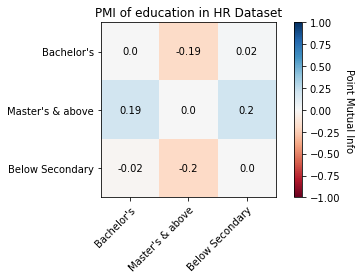

In [14]:
 %matplotlib inline 
educations = train_df['education'].unique()
education_dp_values = feat_measures1[feat_measures1["FeatureName"] == 'education'][["ClassA", "ClassB", "pmi"]]
education_dp_array = np.zeros((len(educations), len(educations)))

for idx, row in education_dp_values.iterrows():
    class_a = row[0]
    class_b = row[1]
    dp_value = row[2]
    i, j = np.where(educations==class_a)[0][0], np.where(educations == class_b)
    dp_value = round(dp_value, 2)
    education_dp_array[i, j] = dp_value
    education_dp_array[j, i] = -1 * dp_value

colormap = "RdBu"
dp_min, dp_max = -1.0, 1.0

fig, ax = plt.subplots()
im = ax.imshow(education_dp_array, vmin=dp_min, vmax=dp_max, cmap=colormap)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Point Mutual Info", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(educations)))
ax.set_yticks(np.arange(len(educations)))
ax.set_xticklabels(educations)
ax.set_yticklabels(educations)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(educations)):
    for j in range(len(educations)):
        text = ax.text(j, i, education_dp_array[i, j], ha="center", va="center", color="k")
    
ax.set_title("PMI of education in HR Dataset")
fig.tight_layout()
plt.show()

Next we can take a look at the distribution balance measures. These measures each of the columns of interest that we selected to the uniform distribution of those values. Values that are closer to zero indicate that the difference between the actual distribution of the data and the uniform distribution of values.

In [15]:
dist_measures = DistributionBalanceMeasure( cols_of_interest)
dist_measures1 = dist_measures.measures(train_df)
dist_measures1


,FeatureName,kl_divergence,js_dist,wasserstein_dist,inf_norm_dist,total_variation_dist,chi_sq_p_value,chi_sq_stat
0,education,0.433445,0.358342,0.235238,0.352857,0.352857,0.0,30235.985340
1,recruitment_channel,0.326923,0.315666,0.208217,0.312326,0.312326,0.0,20356.403343


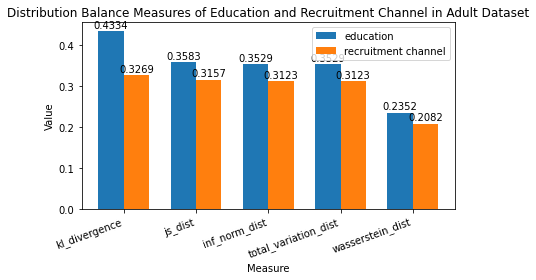

In [16]:
 %matplotlib inline 
measures_of_interest = ["kl_divergence", "js_dist", "inf_norm_dist", "total_variation_dist", "wasserstein_dist"]
education_measures = dist_measures1[dist_measures1['FeatureName'] == 'education'].iloc[0]
department_measures = dist_measures1[dist_measures1['FeatureName'] == 'recruitment_channel'].iloc[0]
education_array = [round(education_measures[measure], 4) for measure in measures_of_interest]
department_array = [round(department_measures[measure], 4) for measure in measures_of_interest]

x = np.arange(len(measures_of_interest))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, education_array, width, label="education")
rects2 = ax.bar(x + width/2, department_array, width, label="recruitment channel")

ax.set_xlabel("Measure")
ax.set_ylabel("Value")
ax.set_title("Distribution Balance Measures of Education and Recruitment Channel in Adult Dataset")
ax.set_xticks(x)
ax.set_xticklabels(measures_of_interest)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="default")

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 1 point vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

We can also look at aggregate balance measures which indicate a notion of overall inequality in the data. We can see that the Atkinson Index is 0.79. This means that in order to create a perfectly balanced dataset over these measures we would need to forgo 79.9% of the data. 

In [17]:
agg_measures = AggregateBalanceMeasure( cols_of_interest)
agg_measures1 = agg_measures.measures(train_df)
agg_measures1

,theil_l_index,theil_t_index,atkinson_index
0,1.60865,0.760961,0.799842


### Error Mitigation: Rebalancing dataset
In order to rebalance the data we can choose from three different methods of under or oversampling. These are SMOTE, Tomek and SMOTE-Tomek. SMOTE is a oversampling technique for the less represented class. Tomek is an undersampling technique that would be applied to the more represented class. Smote-Tomek is when both of these methods are applied in conjunction on the dataset. In this example, we will choose to use the SMOTE sampling technique on the columns of interest. The Rebalance function can only be applied on one column at a time so in order to apply this rebalancing technique on a cohort of two sensitive columns instead of an individual column, we combine these two columns into a single column that can be balanced. 

In [18]:
smote = SMOTE()
# these are the other balance algorithm objects we could use but
#  we are using the SMOTE resampling technique in this example
# smote_tomek = SMOTETomek()
# tomek = TomekLinks()

def combine_cols(df):
    return str(df[0]) + " * " + str(df[1])

train_df2 = train_df
train_df2[categorical_cols] = ord_enc.transform(train_df[categorical_cols])
train_df2["education_recruitment_cohort"] = df[["education", "recruitment_channel"]].apply(combine_cols, axis=1)
train_df2 = train_df2.drop(["education", "recruitment_channel"], axis=1)

In [19]:
data_balance_smote = Rebalance(train_df2, 'education_recruitment_cohort', 'auto', 42, None, smote, None)

smote_df = data_balance_smote.rebalance()
smote_df['education'] = smote_df['education_recruitment_cohort'].apply(lambda x: int(x.split(" * ")[0]))
smote_df['recruitment_channel'] = smote_df['education_recruitment_cohort'].apply(lambda x: int(x.split(" * ")[1]))
smote_df = smote_df.drop(["education_recruitment_cohort"], axis=1)

TODO size of dataset

### New Model on Rebalanced Datasets
After applying the SMOTE Method on the data, we can then train a new lightGBM model on this newly balanced data and see if there are differences in model performance based on this balancing. We compare the results below and find that the new model trained on the data post rebalancing does a better job predicting true positives than the original model and thus has greater recall and overall precision. So not only does data rebalancing help with making sure a model is less biased, it also helps the model actually fit and be able to predict the data outcomes more accurately. 

In [20]:
target_index = smote_df.columns.get_loc('is_promoted')
data_split =  Split(smote_df,target_index , 0.9, 42, False, False, False, True)
train_data, test_data = data_split.split()
# splitting the training data
x_train2, y_train2 = split_label(train_data)
# splitting the test data
x_test2, y_test2 = split_label(test_data)

# LGBMClassifier Model
clf2 = LGBMClassifier(n_estimators=50)
model2 = clf2.fit(x_train2, y_train2, categorical_feature = categorical_cols)

pred2 = model2.predict(x_test2)
# reorders the columns to fit the second model since there is some rearranging
pred_model1 = model.predict(x_test2.reindex(columns = x_test.columns))

def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, normalize='true')
    return pd.DataFrame([[f'TP = {tp} ({tpr:1.2%})', f'FN = {fn} ({fnr:1.2%})'], 
                         [f'FP = {fp} ({fpr:1.2%})', f'TN = {tn} ({tnr:1.2%})']],
                        index=['True', 'False'], 
                        columns=['Pred 1', 'Pred 0'])


Using categorical_feature in Dataset.


We compare the number of error that the model 1 that was trained before rebalancing and model 2 that was trained after rebalancing have and we find that overall there are less errors with model 2. 

In [21]:
# Compare Results
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


print('')
print(color.PURPLE + color.BOLD + "BEFORE: " + color.END + "number of test dataset instances: " + color.BOLD   + color.GREEN + str(len(y_test2)) + color.END)
print("      : number of errors on test dataset: " + color.BOLD   + color.RED + str(sum(pred_model1 != y_test2)) + color.END)
print('')
print(color.PURPLE + color.BOLD + "AFTER:  " + color.END + "number of test dataset instances: " + color.BOLD   + color.GREEN + str(len(y_test2)) + color.END)
print("     :  number of errors on test dataset: " + color.BOLD  + color.RED + str(sum(pred2 != y_test2)) + color.END)
print('')


BEFORE: number of test dataset instances: 14923
      : number of errors on test dataset: 628

AFTER:  number of test dataset instances: 14923
     :  number of errors on test dataset: 367



In [22]:
# compare conf matrices
print("-----------------------------------------------------------------------")
print('')
print(color.BLUE + color.BOLD +"BEFORE: conf_matrix:" + color.END)
print("--------------------")
print(conf_matrix(y_test2,pred_model1) )
print('')
print(color.BLUE + color.BOLD +"AFTER: conf_matrix:" + color.END)
print("-------------------")
print(conf_matrix(y_test2,pred2))
print("-----------------------------------------------------------------------")
print("-----------------------------------------------------------------------")
print('')

-----------------------------------------------------------------------

BEFORE: conf_matrix:
--------------------
                  Pred 1               Pred 0
True   TP = 250 (43.40%)    FN = 326 (56.60%)
False   FP = 302 (2.10%)  TN = 14045 (97.90%)

AFTER: conf_matrix:
-------------------
                  Pred 1               Pred 0
True   TP = 235 (40.80%)    FN = 341 (59.20%)
False    FP = 26 (0.18%)  TN = 14321 (99.82%)
-----------------------------------------------------------------------
-----------------------------------------------------------------------



TODO call out which improved

In [23]:
# compare classification report
print(color.YELLOW + color.BOLD +"BEFORE: classification_report:" + color.END)
print("--------------------------------")
print(classification_report(y_test2, pred_model1)) 
print(color.YELLOW + color.BOLD +"AFTER: classification_report:" + color.END)
print("--------------------------------")
print(classification_report(y_test2, pred2)) 

BEFORE: classification_report:
--------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14347
           1       0.45      0.43      0.44       576

    accuracy                           0.96     14923
   macro avg       0.72      0.71      0.71     14923
weighted avg       0.96      0.96      0.96     14923

AFTER: classification_report:
--------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     14347
           1       0.90      0.41      0.56       576

    accuracy                           0.98     14923
   macro avg       0.94      0.70      0.77     14923
weighted avg       0.97      0.98      0.97     14923



We return the dataframe columns to their original form after rebalancing the data. We no longer encode  We want to be able to run the data balance analysis again on the newly rebalanced data and see what the difference is from before applying SMOTE and after.

In [24]:
smote_df[categorical_cols] = ord_enc.inverse_transform(smote_df[categorical_cols]) 

The feature value measures before rebalancing don't indicate a lot of discrepancy in the outcome within specific features within a class since the values such as demographic parity which is on a 0 to 1 scale are very close to zero. After rebalancing, we still have similarly low values of these measures but there is not a significant improvement since they already started low.

todo feat balance comparison

In [25]:
feat_measures1.head()

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,Bachelor's,Master's & above,education,-0.016964,-0.188396,-0.004202,-0.004908,-4.957166,0.625158,-0.260358,0.409471
1,Bachelor's,Below Secondary,education,0.001259,0.015504,0.064587,0.070209,-31.829677,4.281150,-2.863668,0.051688
2,Master's & above,Below Secondary,education,0.018223,0.203900,0.068788,0.075116,-26.872510,3.655992,-2.603310,0.060643
0,sourcing,other,recruitment_channel,0.003066,0.035499,-0.000410,-0.000477,1.576541,-0.234355,0.084912,0.470033
1,sourcing,referred,recruitment_channel,-0.035991,-0.343135,0.048845,0.053990,-18.710400,2.661363,-1.731014,0.112794


In [26]:
feature_measures.measures(smote_df).head()

,ClassA,ClassB,FeatureName,dp,pmi,sdc,ji,krc,llr,t_test,ttest_pvalue
0,Bachelor's,Master's & above,education,0.015560,0.298522,0.013946,0.015359,0.114227,0.298522,0.0,0.5
1,Bachelor's,Below Secondary,education,0.049595,1.729391,0.044451,0.047445,0.364080,1.729391,0.0,0.5
2,Master's & above,Below Secondary,education,0.034035,1.430869,0.030505,0.032087,0.249853,1.430869,0.0,0.5
0,sourcing,other,recruitment_channel,0.002674,0.056768,0.002396,0.002612,0.019628,0.056768,0.0,0.5
1,sourcing,referred,recruitment_channel,0.026959,0.812903,0.024163,0.025756,0.197905,0.812903,0.0,0.5


When we compare the distribution measures before and after rebalancing, we find that the data is much more evenly distributed (close to the uniform distribution) for the two columns of interest after rebalancing the data using the SMOTE algorithm

In [27]:
#before
dist_measures1

,FeatureName,kl_divergence,js_dist,wasserstein_dist,inf_norm_dist,total_variation_dist,chi_sq_p_value,chi_sq_stat
0,education,0.433445,0.358342,0.235238,0.352857,0.352857,0.0,30235.985340
1,recruitment_channel,0.326923,0.315666,0.208217,0.312326,0.312326,0.0,20356.403343


In [28]:
#after
dist_measures.measures(smote_df)


,FeatureName,kl_divergence,js_dist,wasserstein_dist,inf_norm_dist,total_variation_dist,chi_sq_p_value,chi_sq_stat
0,education,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,recruitment_channel,0.0,0.0,0.0,0.0,0.0,1.0,0.0


The Atkinson index which gives us the overall notion of inequality before and after rebalancing shows us that in order to get a perfectly balanced dataset, we no longer need to forgo any of the data.

In [29]:
#before
agg_measures1

,theil_l_index,theil_t_index,atkinson_index
0,1.60865,0.760961,0.799842


In [30]:
#after
agg_measures.measures(smote_df)

,theil_l_index,theil_t_index,atkinson_index
0,0.0,0.0,0.0


In [34]:
model2 = clf.fit(x_train, y_train)
predictions2 = model2.predict(x_test)
#ErrorAnalysisDashboard(dataset=x_test, true_y=y_test, features=x_test.columns, pred_y=predictions2, categorical_features = categorical_cols)

label the top as before and the bottom as after
highlight underneath the cohort
lower fill (meaning )

![error_analysis2](images/error_analysis2.png)